In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import tensorflow
import missingno as msno
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score, f1_score, roc_auc_score,roc_curve,auc
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

# Просмотр и знакомство с датасетом

Отображение первых пяти признаков

In [ ]:
df = pd.read_csv(
    "cardio_train-2.csv",delimiter=';',nrows=10000
    )#nrows - how many values ​​we are considering
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Пользовательская функция для перевода количества дней в года

In [ ]:
days  = 365

def change_values(n):
    return round(n / days)

преобразование значения в колонке 'age' нашего DataFrame `df`

In [ ]:
df['age'] = df['age'].apply(change_values)

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
df = df.drop(columns=('id'))


Анализ пропущенных данных, видим что пропущенные значения отсутсвуют  

In [ ]:
columns_to_check = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
missing_values_dict = {col: df[col].isnull().sum() for col in columns_to_check}
print(missing_values_dict)


{'age': 0, 'gender': 0, 'height': 0, 'weight': 0, 'ap_hi': 0, 'ap_lo': 0, 'cholesterol': 0, 'gluc': 0, 'smoke': 0, 'alco': 0, 'active': 0, 'cardio': 0}


In [ ]:
'''в общих сведениях также можно заметить,
что пропущенные значения отсутствуют'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          10000 non-null  int64  
 1   gender       10000 non-null  int64  
 2   height       10000 non-null  int64  
 3   weight       10000 non-null  float64
 4   ap_hi        10000 non-null  int64  
 5   ap_lo        10000 non-null  int64  
 6   cholesterol  10000 non-null  int64  
 7   gluc         10000 non-null  int64  
 8   smoke        10000 non-null  int64  
 9   alco         10000 non-null  int64  
 10  active       10000 non-null  int64  
 11  cardio       10000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 937.6 KB


Визуализация отсутсвия пропущенных данных



<Axes: >

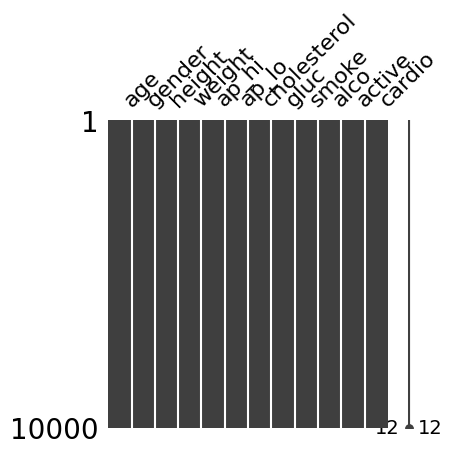

In [ ]:
msno.matrix(df,figsize=(4,4))

# Статический анализ данных

Вычисляем статистику для каждой колонки / агрегирование данных


In [ ]:
stats_df = pd.DataFrame(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
for col in df.columns:
    count = len(df[col])
    mean = sum(df[col]) / count
    std = (sum((x - mean) ** 2 for x in df[col]) / count) ** 0.5
    min_val = min(df[col])
    q25 = sorted(df[col])[int(0.25 * count)]
    median = sorted(df[col])[int(0.5 * count)]
    q75 = sorted(df[col])[int(0.75 * count)]
    max_val = max(df[col])
    stats_df[col] = [count, mean, std, min_val, q25, median, q75, max_val]

pd.DataFrame(stats_df)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,53.288300,1.345400,164.308200,74.303710,128.037000,97.954100,1.365000,1.222200,0.089000,0.053700,0.797200,0.50310
std,6.795895,0.475499,8.178387,14.565624,116.829772,207.187597,0.677625,0.565533,0.284744,0.225425,0.402085,0.49999
min,30.000000,1.000000,70.000000,30.000000,-100.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.00000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.00000
max,65.000000,2.000000,250.000000,200.000000,11500.000000,10000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.00000


Встроенным методом

In [ ]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,53.288300,1.345400,164.308200,74.303710,128.037000,97.954100,1.365000,1.222200,0.089000,0.053700,0.797200,0.503100
std,6.796234,0.475522,8.178796,14.566353,116.835614,207.197957,0.677658,0.565561,0.284758,0.225436,0.402105,0.500015
min,30.000000,1.000000,70.000000,30.000000,-100.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,200.000000,11500.000000,10000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Вычисляем корреляцию между всеми парами признаков


In [ ]:
import pandas as pd

def custom_corr(df):
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
    for i in df.columns:
        for j in df.columns:
            mean_i, mean_j = df[i].mean(), df[j].mean()
            std_i, std_j = df[i].std(), df[j].std()
            corr_matrix.loc[i, j] = ((df[i] - mean_i) * (df[j] - mean_j)).mean() / (std_i * std_j)
    return corr_matrix

pd.DataFrame(custom_corr(df))



,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,0.999900,-0.016548,-0.079197,0.046661,0.034856,0.022042,0.172916,0.091017,-0.049636,-0.043588,-0.022663,0.237052
gender,-0.016548,0.999900,0.494896,0.149231,-0.001233,0.005355,-0.032805,-0.025835,0.332027,0.179590,0.011752,0.002226
height,-0.079197,0.494896,0.999900,0.290473,0.013907,0.006534,-0.044979,-0.024425,0.193033,0.112567,-0.010550,-0.008352
weight,0.046661,0.149231,0.290473,0.999900,0.039453,0.047313,0.132111,0.100909,0.066393,0.079250,-0.020921,0.183306
ap_hi,0.034856,-0.001233,0.013907,0.039453,0.999900,0.018939,0.025018,0.007308,-0.002480,0.000475,0.007061,0.071287
ap_lo,0.022042,0.005355,0.006534,0.047313,0.018939,0.999900,0.025163,0.008360,0.000286,-0.006734,-0.002321,0.077044
cholesterol,0.172916,-0.032805,-0.044979,0.132111,0.025018,0.025163,0.999900,0.431556,0.024434,0.019634,0.018797,0.221251
gluc,0.091017,-0.025835,-0.024425,0.100909,0.007308,0.008360,0.431556,0.999900,0.017536,0.013866,0.004671,0.082433
smoke,-0.049636,0.332027,0.193033,0.066393,-0.002480,0.000286,0.024434,0.017536,0.999900,0.329010,0.031870,-0.018091
alco,-0.043588,0.179590,0.112567,0.079250,0.000475,-0.006734,0.019634,0.013866,0.329010,0.999900,0.037401,-0.006356


Встроенным методом

In [ ]:
df.corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.016550,-0.079205,0.046665,0.034859,0.022045,0.172934,0.091026,-0.049640,-0.043592,-0.022665,0.237076
gender,-0.016550,1.000000,0.494945,0.149246,-0.001233,0.005356,-0.032808,-0.025837,0.332060,0.179608,0.011753,0.002226
height,-0.079205,0.494945,1.000000,0.290502,0.013908,0.006535,-0.044984,-0.024428,0.193053,0.112578,-0.010551,-0.008353
weight,0.046665,0.149246,0.290502,1.000000,0.039457,0.047318,0.132124,0.100919,0.066399,0.079258,-0.020923,0.183325
ap_hi,0.034859,-0.001233,0.013908,0.039457,1.000000,0.018941,0.025021,0.007308,-0.002480,0.000475,0.007061,0.071295
ap_lo,0.022045,0.005356,0.006535,0.047318,0.018941,1.000000,0.025165,0.008360,0.000286,-0.006734,-0.002322,0.077051
cholesterol,0.172934,-0.032808,-0.044984,0.132124,0.025021,0.025165,1.000000,0.431599,0.024436,0.019636,0.018799,0.221273
gluc,0.091026,-0.025837,-0.024428,0.100919,0.007308,0.008360,0.431599,1.000000,0.017538,0.013867,0.004671,0.082441
smoke,-0.049640,0.332060,0.193053,0.066399,-0.002480,0.000286,0.024436,0.017538,1.000000,0.329043,0.031873,-0.018093
alco,-0.043592,0.179608,0.112578,0.079258,0.000475,-0.006734,0.019636,0.013867,0.329043,1.000000,0.037405,-0.006357


Построение тепловой карты корреляции признаков

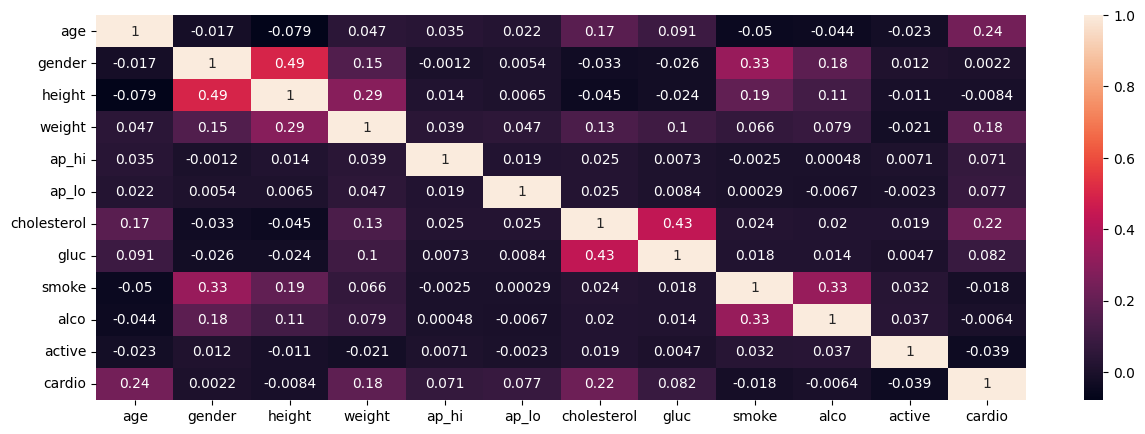

In [ ]:
plt.figure(figsize=(15,5))
hot_map = sns.heatmap(df.corr(),annot=True)

# Масштабирование

Создание матрицы признаков и целовой переменной

In [ ]:
X_matrixofevidence = df.drop(['cardio'],axis=1)
Y_target = df['cardio']

Нормализуем данные при помощи StandartScaler()

In [ ]:
normalizer = StandardScaler()
X_normalized_datafame = pd.DataFrame(normalizer.fit_transform(X_matrixofevidence), columns=X_matrixofevidence.columns)
X_normalized = normalizer.fit_transform(X_matrixofevidence)
X_normalized


array([[-0.48386566,  1.37666044,  0.45140931, ..., -0.31256174,
        -0.23821698,  0.50437126],
       [ 0.25187265, -0.72639554, -1.0158727 , ..., -0.31256174,
        -0.23821698,  0.50437126],
       [-0.18957033, -0.72639554,  0.08458881, ..., -0.31256174,
        -0.23821698, -1.9826665 ],
       ...,
       [-1.95534228, -0.72639554, -0.7713257 , ..., -0.31256174,
        -0.23821698,  0.50437126],
       [-0.48386566, -0.72639554,  0.45140931, ..., -0.31256174,
        -0.23821698,  0.50437126],
       [ 0.10472499,  1.37666044, -0.15995819, ..., -0.31256174,
        -0.23821698,  0.50437126]])

# Обучение модели с помощью Logistic Regression


Разделение данных на обучающий и тестовый наборы

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y_target, test_size=0.2, random_state=0)

Создание и обучение логистической регрессии

In [ ]:
logicstic_model = LogisticRegression()
logicstic_model.fit(X_train,Y_train)

LogisticRegression()

Предсказание и оценка модели с отчетом о классификации

In [ ]:
another_model = logicstic_model.predict(X_test)
accuracy = accuracy_score(Y_test, another_model)

print(accuracy)

report = classification_report(Y_test, another_model)
print(report)

0.7195
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       991
           1       0.75      0.67      0.71      1009

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



In [ ]:
predicted_probs = logicstic_model.predict_proba(X_test)[:, 1]

re_lst = []
pre_lst = []
F1_lst = []
tresholds = np.arange(0, 1, 0.01)

for treshold in tresholds:
    classes = (predicted_probs > treshold).astype(int)
    re_lst.append(recall_score(Y_test, classes))
    pre_lst.append(precision_score(Y_test, classes))
    F1_lst.append(f1_score(Y_test, classes))


Предсказание вероятностей и вычисление метрик качества

Визуализация метрик качества

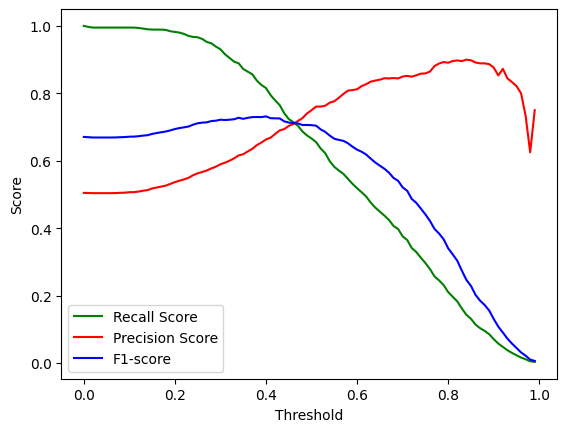

In [ ]:
plt.plot(tresholds, re_lst, c='g', label='Recall Score')
plt.plot(tresholds, pre_lst, c='r', label='Precision Score')
plt.plot(tresholds, F1_lst, c='b', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

Предсказание классов на основе порога вероятности и вычисление метрик качества


In [ ]:
lr_pred = predicted_probs > 0.7

accuracy = accuracy_score(Y_test, lr_pred)
print("Accuracy:", accuracy)
print(classification_report(Y_test,lr_pred))

Accuracy: 0.6515
              precision    recall  f1-score   support

           0       0.59      0.93      0.73       991
           1       0.85      0.38      0.52      1009

    accuracy                           0.65      2000
   macro avg       0.72      0.65      0.62      2000
weighted avg       0.72      0.65      0.62      2000

0.65400547444343


# Обучение модели с помощью SVM

Создание и обучение модели SVM




In [ ]:
svm = SVC(kernel='linear',probability=True)
X_train, X_test,Y_train,Y_test = train_test_split(X_matrixofevidence,Y_target,test_size=0.2,random_state=0)
svm.fit(X_train,Y_train)
another_model = svm.predict(X_test)

Предсказание классов и вычисление отчета о классификации

In [ ]:
another_model = svm.predict(X_test)
accuracy = accuracy_score(Y_test, another_model)

print(accuracy)

report = classification_report(Y_test, another_model)
print(report)

0.726
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       991
           1       0.79      0.62      0.70      1009

    accuracy                           0.73      2000
   macro avg       0.74      0.73      0.72      2000
weighted avg       0.74      0.73      0.72      2000



In [ ]:
roc_auc_score(Y_test, another_model)

0.7269498829405182

Предсказание вероятностей и вычисление метрик качества

In [ ]:
svm_probs = svm.predict_proba(X_test)[:,1]

re_lst = []
pre_lst = []
F1_lst = []
tresholds = np.arange(0, 1, 0.01)

for treshold in tresholds:
    classes = (svm_probs > treshold).astype(int)
    re_lst.append(recall_score(Y_test, classes))
    pre_lst.append(precision_score(Y_test, classes))
    F1_lst.append(f1_score(Y_test, classes))

Визуализация метрик качества

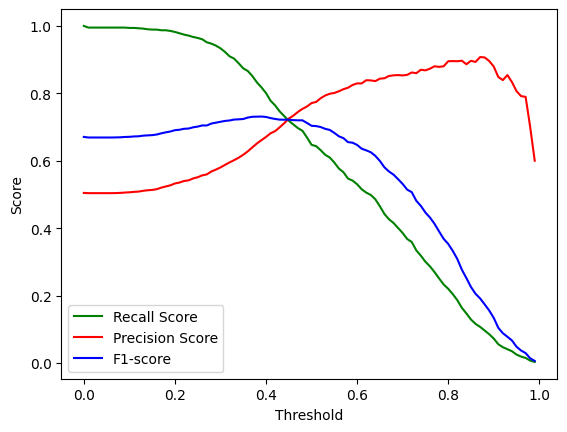

In [ ]:
plt.plot(tresholds, re_lst, c='g', label='Recall Score')
plt.plot(tresholds, pre_lst, c='r', label='Precision Score')
plt.plot(tresholds, F1_lst, c='b', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

Предсказание классов на основе порога вероятности и вычисление метрик качества

In [ ]:
svm_pred = (svm_probs > 0.7).astype(int)
accuracy = accuracy_score(Y_test, svm_pred)
print("Accuracy:", accuracy)
print(classification_report(Y_test,svm_pred))

Accuracy: 0.6565
              precision    recall  f1-score   support

           0       0.60      0.93      0.73       991
           1       0.85      0.39      0.53      1009

    accuracy                           0.66      2000
   macro avg       0.73      0.66      0.63      2000
weighted avg       0.73      0.66      0.63      2000

0.6589608758309423


 Визуализация ROC-кривой Logistic Regression и  SVM

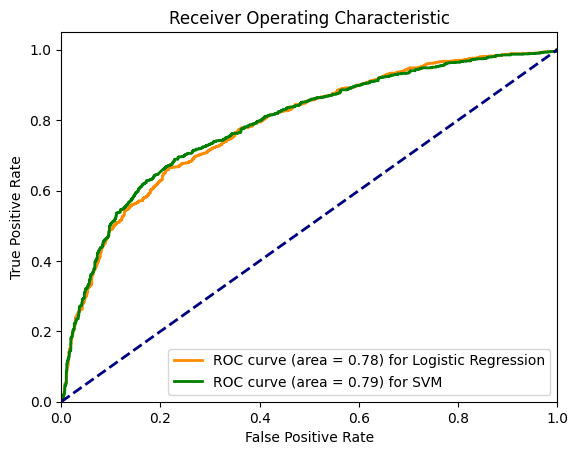

In [ ]:
Y_score_lr = logicstic_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(Y_test, Y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

Y_score_svm = svm.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(Y_test, Y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = %0.2f) for Logistic Regression' % roc_auc_lr)
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label='ROC curve (area = %0.2f) for SVM' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Обучение модели с помощью Decision Tree



Разделение данных на обучающий и тестовый наборы

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_matrixofevidence, Y_target, test_size=0.2, random_state=0)


Обучение исходной модели дерева решений с поиском по сетке для первого набора параметров

In [ ]:
three_tree = DecisionTreeClassifier(random_state=0)
tree_params = {"max_depth": np.arange(1, 11), "max_features": [0.5, 0.7, 1]}
tree_grid = GridSearchCV(three_tree, tree_params, cv=5, n_jobs=-1)
tree_grid.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'max_features': [0.5, 0.7, 1]})

Поиск оптимальных параметров для нового диапазона max_features



In [ ]:
max_features = {'max_features': [0.4, 0.45, 0.55, 0.6]}
tree_grid_features = GridSearchCV(three_tree, max_features, cv=5, n_jobs=-1)
tree_grid_features.fit(X_train, Y_train)



GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_features': [0.4, 0.45, 0.55, 0.6]})

Вывод лучших/оптимальных параметров и получение лучшей модели

In [ ]:
print(f'Оптимальные параметры модели:')
print(f" 'max_depth' : {tree_grid.best_params_['max_depth']}")
print(f" 'max_features' : {tree_grid_features.best_params_['max_features']}")


Оптимальные параметры модели:
 'max_depth' : 5
 'max_features' : 0.4


Создание и обучение модели дерева решений с оптимальными параметрами

In [ ]:
three_tree_test = DecisionTreeClassifier(max_depth=tree_grid.best_params_['max_depth'],
                                         max_features=tree_grid_features.best_params_['max_features'],
                                         random_state=0)
three_tree_test.fit(X_train, Y_train)


DecisionTreeClassifier(max_depth=5, max_features=0.4, random_state=0)

Предсказание и оценка модели на тестовом наборе данных

In [ ]:
three_tree_test_predict = three_tree_test.predict(X_test)
print(classification_report(Y_test, three_tree_test_predict))


              precision    recall  f1-score   support

           0       0.70      0.79      0.74       991
           1       0.76      0.67      0.71      1009

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



# Обучение модели с помощью Gradient Boosting

Разделение данных на обучающий и тестовый наборы

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_matrixofevidence, Y_target, test_size=0.2, random_state=0)


Обучение модели с использованием GridSearchCV для подбора лучших параметров

In [ ]:
gbdt_model = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None]
}

grid_search = GridSearchCV(estimator=gbdt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'max_features': ['sqrt', None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy')

Вывод лучших/оптимальных параметров и получение лучшей модели

In [ ]:
print(f'Оптимальные параметры модели:' )
print()
print(f" 'learning_rate' : {grid_search.best_params_['learning_rate']}")
print(f" 'max_depth' : {grid_search.best_params_['max_depth']}")
print(f" 'max_features' : {grid_search.best_params_['max_features']}")
print(f" 'min_samples_leafs' : {grid_search.best_params_['min_samples_leaf']}")
print(f" 'min_samples_split' : {grid_search.best_params_['min_samples_split']}")
print(f" 'n_estimators' : {grid_search.best_params_['n_estimators']}")

Оптимальные параметры модели:

 'learning_rate' : 0.01
 'max_depth' : 5
 'max_features' : sqrt
 'min_samples_leafs' : 2
 'min_samples_split' : 2
 'n_estimators' : 200


 Предсказание и оценка модели на тестовом наборе данных

In [ ]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
predicted_probs = best_model.predict_proba(X_test)[:, 1]
print(classification_report(Y_test, predictions))


              precision    recall  f1-score   support

           0       0.70      0.80      0.75       991
           1       0.77      0.67      0.71      1009

    accuracy                           0.73      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.74      0.73      0.73      2000



 Визуализация ROC-кривой Decision Tree и  Gradient Boosting

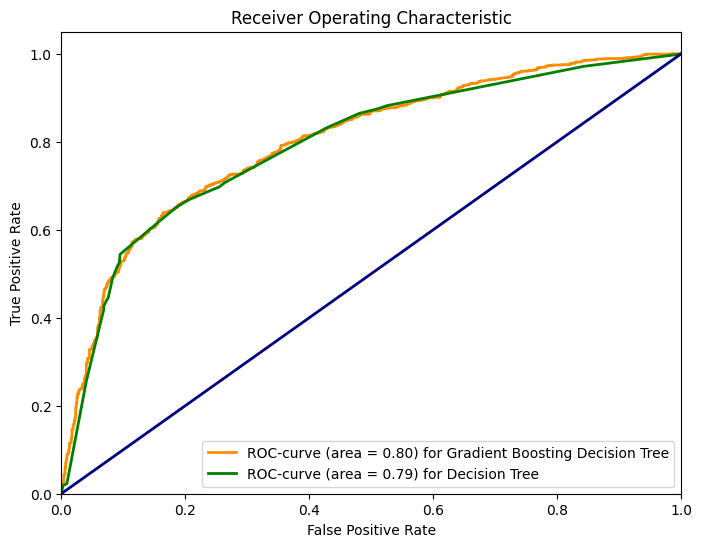

In [ ]:
predicted_probs = best_model.predict_proba(X_test)[:, 1]
fpr_gbdt, tpr_gbdt, _ = roc_curve(Y_test, predicted_probs)
roc_auc_gbdt = auc(fpr_gbdt, tpr_gbdt)
fpr_tree, tpr_tree, _ = roc_curve(Y_test, Y_prob[:, 1])
roc_auc_tree = auc(fpr_tree, tpr_tree)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gbdt, tpr_gbdt, color='darkorange',
         lw=2, label='ROC-curve (area = %0.2f) for Gradient Boosting Decision Tree' % roc_auc_gbdt)
plt.plot(fpr_tree, tpr_tree, color='green',
         lw=2, label='ROC-curve (area = %0.2f) for Decision Tree'  % roc_auc_tree)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()